In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

#import numpy as np # linear algebra
#import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

#import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

%matplotlib inline

In [3]:
train_classes = pd.read_csv('/kaggle/input/planets-dataset/planet/planet/train_classes.csv')
train_classes.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [4]:
sample_submission = pd.read_csv('/kaggle/input/planets-dataset/planet/planet/sample_submission.csv')
sample_submission.head()

,image_name,tags
0,test_0,primary clear agriculture road water
1,test_1,primary clear agriculture road water
2,test_2,primary clear agriculture road water
3,test_3,primary clear agriculture road water
4,test_4,primary clear agriculture road water


In [5]:
test1 = !ls ../input/planets-dataset/planet/planet/test-jpg | wc -l
test2 = !ls ../input/planets-dataset/test-jpg-additional/test-jpg-additional | wc -l

print(train_classes.shape[0])
print(sample_submission.shape[0])
print(float(test1[0]) + float(test2[0]))

40479
61191
61191.0


In [6]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
image_path = '../input/planets-dataset/planet/planet/train-jpg/train_2.jpg'
image = tf.keras.preprocessing.image.load_img(image_path, grayscale = False)
image_2 = keras.preprocessing.image.img_to_array(image)
image_2.shape

(256, 256, 3)

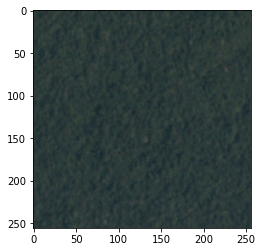

In [7]:
plt.imshow((image_2/255))

In [8]:
train_classes_df = train_classes.copy()

In [9]:
from itertools import chain
all_labels = list(chain.from_iterable([tag.split(' ')for tag in train_classes_df.tags.values]))
labels = list(set(all_labels))
print('There are {} labels and they are {}' .format(len(labels), labels))

There are 17 labels and they are ['agriculture', 'bare_ground', 'partly_cloudy', 'blooming', 'cloudy', 'cultivation', 'haze', 'primary', 'artisinal_mine', 'conventional_mine', 'blow_down', 'selective_logging', 'habitation', 'slash_burn', 'clear', 'road', 'water']


In [10]:
#one hot encoding
for tag in labels:
    train_classes_df[tag] = train_classes_df.tags.apply(lambda x: 1 if tag in x.split() else 0)

# adding '.jpg' extension to 'image_name'
train_classes_df['image_name'] = train_classes_df['image_name'].apply(lambda x: '{}.jpg'.format(x)) 
train_classes_df.head()

,image_name,tags,agriculture,bare_ground,partly_cloudy,blooming,cloudy,cultivation,haze,primary,artisinal_mine,conventional_mine,blow_down,selective_logging,habitation,slash_burn,clear,road,water
0,train_0.jpg,haze primary,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0
1,train_1.jpg,agriculture clear primary water,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1
2,train_2.jpg,clear primary,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0
3,train_3.jpg,clear primary,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0
4,train_4.jpg,agriculture clear habitation primary road,1,0,0,0,0,0,0,1,0,0,0,0,1,0,1,1,0


In [11]:
#creating an Image generator
image_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)

X = image_gen.flow_from_dataframe(dataframe=train_classes_df, \
                                  directory='/kaggle/input/planets-dataset/planet/planet/train-jpg/', \
                                  x_col='image_name', y_col=labels,\
                                  target_size=(128, 128), class_mode='raw', seed=1, batch_size=128)

Found 40479 validated image filenames.


In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau, History

In [13]:
def my_accuracy(y_true , y_pred, epsilon=1e-4):
    
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(tf.greater(tf.cast(y_pred, tf.float32), tf.constant(0.5)), tf.float32)
    
    tp = tf.reduce_sum(y_true * y_pred, axis=1)
    fp = tf.reduce_sum(y_pred, axis=1) - tp
    fn = tf.reduce_sum(y_true, axis=1) - tp
    
    y_true = tf.cast(y_true, tf.bool)
    y_pred = tf.cast(y_pred, tf.bool)
    
    tn = tf.reduce_sum(tf.cast(tf.logical_not(y_true), tf.float32) * tf.cast(tf.logical_not(y_pred), tf.float32),\
                       axis=1)
    pred_accuracy = (tp+tn)/(tp+tn+fp+fn+epsilon)
    return pred_accuracy

In [14]:
def my_fbeta(y_true , y_pred, beta=2, epsilon=1e-4):

    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(tf.greater(tf.cast(y_pred, tf.float32), tf.constant(0.5)), tf.float32)
        
    tp = tf.reduce_sum(y_true * y_pred, axis=1)
    fp = tf.reduce_sum(y_pred, axis=1) - tp
    fn = tf.reduce_sum(y_true, axis=1) - tp
    
    precision = tp/(tp+fp+epsilon)
    recall = tp/(tp+fn+epsilon)
    
    pred_fbeta = (1+(beta**2))*precision*recall / ((beta**2)*precision + recall + epsilon)
    return pred_fbeta

In [15]:
def build_model():
    model = Sequential()
    model.add(Conv2D(input_shape=(128,128,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
    model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
    model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(512, activation='relu'))
    model.add(Dense(512, activation='relu'))
    model.add(Dense(512, activation='relu'))
    model.add(Dense(512, activation='relu'))
    model.add(Dense(len(labels), activation='sigmoid'))

    opt = Adam(lr=1e-4)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=[my_accuracy, my_fbeta])
    
    return model

In [16]:
history = History()
callbacks = [history, 
             EarlyStopping(monitor='val_loss', patience=3, verbose=1, min_delta=1e-4),
             ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=1, cooldown=0, min_lr=1e-7, verbose=1),
             ModelCheckpoint(filepath='weights_best.hdf5', monitor = 'val_fbeta', verbose=1, save_best_only=True, 
                             save_weights_only=True, mode='max')]

In [17]:
train_image_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255,validation_split=0.2)

# generating the 80% training image data
train_gen = train_image_gen.flow_from_dataframe(dataframe=train_classes_df,
                                                directory='../input/planets-dataset/planet/planet/train-jpg/',
                                                x_col='image_name', y_col=labels, target_size=(128, 128), 
                                                class_mode='raw', seed=0, batch_size=128, subset='training')

# generating the 20% validation image data
val_gen = train_image_gen.flow_from_dataframe(dataframe=train_classes_df,
                                              directory='../input/planets-dataset/planet/planet/train-jpg/',
                                              x_col='image_name', y_col=labels,target_size=(128, 128), 
                                              class_mode='raw', seed=0, batch_size=128, subset='validation')

Found 32384 validated image filenames.
Found 8095 validated image filenames.


In [27]:
tf.keras.preprocessing.image.ImageDataGenerator.flow_from_dataframe?

In [18]:
step_train_size = int(np.ceil(train_gen.samples / train_gen.batch_size))
step_val_size = int(np.ceil(val_gen.samples / train_gen.batch_size))

In [19]:
model1 =build_model() 
model1.fit(x=train_gen, steps_per_epoch=step_train_size, validation_data=val_gen, validation_steps=step_val_size,
         epochs=25, callbacks=callbacks)

Epoch 1/25
253/253 [==============================] - 133s 525ms/step - loss: 0.2795 - my_accuracy: 0.9026 - my_fbeta: 0.6418 - val_loss: 0.2407 - val_my_accuracy: 0.9050 - val_my_fbeta: 0.6424
Epoch 2/25
253/253 [==============================] - 107s 425ms/step - loss: 0.2377 - my_accuracy: 0.9052 - my_fbeta: 0.6424 - val_loss: 0.2207 - val_my_accuracy: 0.9075 - val_my_fbeta: 0.6146
Epoch 3/25
253/253 [==============================] - 108s 427ms/step - loss: 0.1921 - my_accuracy: 0.9182 - my_fbeta: 0.7075 - val_loss: 0.1754 - val_my_accuracy: 0.9241 - val_my_fbeta: 0.7337
Epoch 4/25
253/253 [==============================] - 107s 421ms/step - loss: 0.1664 - my_accuracy: 0.9310 - my_fbeta: 0.7686 - val_loss: 0.1598 - val_my_accuracy: 0.9371 - val_my_fbeta: 0.7963
Epoch 5/25
253/253 [==============================] - 106s 420ms/step - loss: 0.1478 - my_accuracy: 0.9404 - my_fbeta: 0.8043 - val_loss: 0.1480 - val_my_accuracy: 0.9407 - val_my_fbeta: 0.8165
Epoch 6/25
253/253 [==========

Text(0.5, 1.0, 'Cross Entropy Loss')

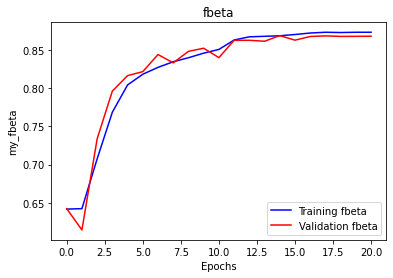

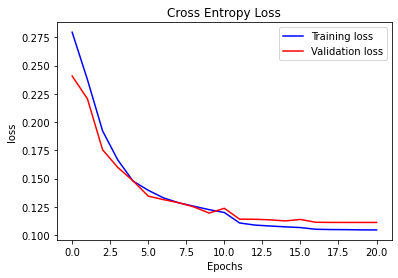

In [25]:
plt.figure()
plt.plot(model1.history.history['my_fbeta'], 'blue')
plt.plot(model1.history.history['val_my_fbeta'], 'red')
plt.legend(['Training fbeta', 'Validation fbeta'])
plt.xlabel('Epochs')
plt.ylabel('my_fbeta')
plt.title('fbeta')
plt.figure()
plt.plot(model1.history.history['loss'], 'blue')
plt.plot(model1.history.history['val_loss'], 'red')
plt.legend(['Training loss', 'Validation loss'])
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.title('Cross Entropy Loss')

Decided to do a Drop Out regularization

In [21]:
from tensorflow.keras.layers import Dropout
def new_model():
    model = Sequential()
    model.add(Conv2D(input_shape=(128,128,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
    model.add(Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.3))

    model.add(Dense(len(labels), activation='sigmoid'))
    
    opt = Adam(lr=1e-4)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=[my_accuracy, my_fbeta])
    
    return model

In [22]:
history = History()
callbacks = [history, 
             EarlyStopping(monitor='val_fbeta', patience=3, verbose=1, min_delta=1e-4),
             ReduceLROnPlateau(monitor='val_fbeta', factor=0.1, patience=1, cooldown=0, min_lr=1e-7, verbose=1),
             ModelCheckpoint(filepath='new_weights_best.hdf5', monitor = 'val_fbeta', verbose=1, save_best_only=True, 
                             save_weights_only=True, mode='max')]
save_best = ModelCheckpoint(filepath='new_weights_best.hdf5', monitor = 'val_fbeta', verbose=1, save_best_only=True, 
                             save_weights_only=True, mode='max')

In [26]:
model_new =new_model() 
model_new.fit(x=train_gen, steps_per_epoch=step_train_size, validation_data=val_gen, validation_steps=step_val_size,
         epochs=25, callbacks=callbacks)

Epoch 1/25
253/253 [==============================] - 113s 447ms/step - loss: 0.2997 - my_accuracy: 0.8848 - my_fbeta: 0.6064 - val_loss: 0.2536 - val_my_accuracy: 0.9058 - val_my_fbeta: 0.6488
Epoch 2/25
253/253 [==============================] - 112s 443ms/step - loss: 0.2317 - my_accuracy: 0.9098 - my_fbeta: 0.6566 - val_loss: 0.2129 - val_my_accuracy: 0.9155 - val_my_fbeta: 0.7180
Epoch 3/25
253/253 [==============================] - 112s 443ms/step - loss: 0.2057 - my_accuracy: 0.9173 - my_fbeta: 0.7003 - val_loss: 0.1881 - val_my_accuracy: 0.9286 - val_my_fbeta: 0.7733
Epoch 4/25
253/253 [==============================] - 112s 442ms/step - loss: 0.1778 - my_accuracy: 0.9307 - my_fbeta: 0.7611 - val_loss: 0.1550 - val_my_accuracy: 0.9382 - val_my_fbeta: 0.7945
Epoch 5/25
253/253 [==============================] - 111s 440ms/step - loss: 0.1606 - my_accuracy: 0.9365 - my_fbeta: 0.7855 - val_loss: 0.1487 - val_my_accuracy: 0.9395 - val_my_fbeta: 0.7996
Epoch 6/25
253/253 [==========

Text(0.5, 1.0, 'Cross Entropy Loss')

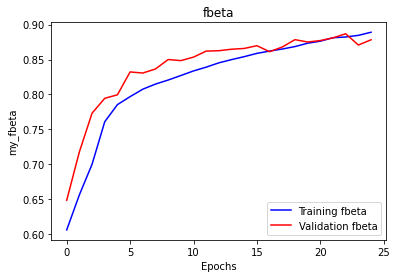

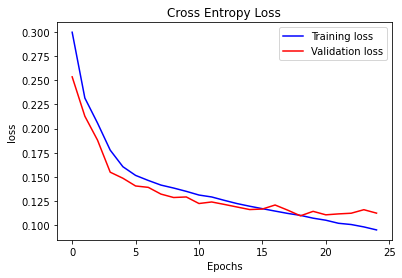

In [30]:
plt.figure()
plt.plot(model_new.history.history['my_fbeta'], 'blue')
plt.plot(model_new.history.history['val_my_fbeta'], 'red')
plt.legend(['Training fbeta', 'Validation fbeta'])
plt.xlabel('Epochs')
plt.ylabel('my_fbeta')
plt.title('fbeta')
plt.figure()
plt.plot(model_new.history.history['loss'], 'blue')
plt.plot(model_new.history.history['val_loss'], 'red')
plt.legend(['Training loss', 'Validation loss'])
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.title('Cross Entropy Loss')

In [34]:
model2 = new_model() # building a sequential model for testing

#loading in the weights of the trained model
model2.load_weights('new_weights_best.hdf5')

OSError: Unable to open file (unable to open file: name = 'new_weights_best.hdf5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [35]:
sample_submission_df = sample_submission.copy()
sample_submission_df['image_name'] = sample_submission_df['image_name'].apply(lambda x: '{}.jpg'.format(x))
sample_submission_df.head()

,image_name,tags
0,test_0.jpg,primary clear agriculture road water
1,test_1.jpg,primary clear agriculture road water
2,test_2.jpg,primary clear agriculture road water
3,test_3.jpg,primary clear agriculture road water
4,test_4.jpg,primary clear agriculture road water


In [36]:
test1_df = sample_submission_df.iloc[:40669]['image_name'].reset_index().drop('index', axis=1)
test1_df.head()

,image_name
0,test_0.jpg
1,test_1.jpg
2,test_2.jpg
3,test_3.jpg
4,test_4.jpg


In [37]:
test_image_gen1 = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)

test_gen1 = test_image_gen1.flow_from_dataframe(dataframe=test1_df,
                                                directory='../input/planets-dataset/planet/planet/test-jpg/', 
                                                x_col='image_name', y_col=None,batch_size=128, shuffle=False,
                                                class_mode=None, target_size=(128, 128))

step_test_size1 = int(np.ceil(test_gen1.samples / test_gen1.batch_size))

Found 40669 validated image filenames.


In [38]:
test_gen1.reset()
pred1 = model_new.predict(test_gen1, steps=step_test_size1, verbose=1)

318/318 [==============================] - 123s 388ms/step


In [40]:
test_file_names_1 = test_gen1.filenames
pred_tags_1 = pd.DataFrame(pred1)
pred_tags_1 = pred_tags_1.apply(lambda x: ' '.join(np.array(labels)[x > 0.5]), axis=1)

result_1 = pd.DataFrame({'image_name': test_file_names_1, 'tags': pred_tags_1})
result_1.head()

,image_name,tags
0,test_0.jpg,primary clear
1,test_1.jpg,primary clear
2,test_2.jpg,partly_cloudy primary
3,test_3.jpg,cultivation primary clear
4,test_4.jpg,partly_cloudy cloudy


In [41]:
test2_df = sample_submission_df.iloc[40669:]['image_name'].reset_index().drop('index', axis=1)
test2_df.head()

,image_name
0,file_0.jpg
1,file_1.jpg
2,file_10.jpg
3,file_100.jpg
4,file_1000.jpg


In [42]:
test_image_gen2 = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)

test_gen2 = test_image_gen2.flow_from_dataframe(dataframe=test2_df, \
            directory='../input/planets-dataset/test-jpg-additional/test-jpg-additional/', x_col='image_name',
                                                y_col=None, batch_size=128, shuffle=False, class_mode=None, 
                                                target_size=(128, 128))

step_test_size2 = int(np.ceil(test_gen2.samples / test_gen2.batch_size))

Found 20522 validated image filenames.


In [43]:
test_gen2.reset()
pred_2 = model_new.predict(test_gen2, steps=step_test_size2, verbose=1)

161/161 [==============================] - 65s 402ms/step


In [44]:
test_file_names_2 = test_gen2.filenames
pred_tags_2 = pd.DataFrame(pred_2)
pred_tags_2 = pred_tags_2.apply(lambda x: ' '.join(np.array(labels)[x > 0.5]), axis=1)

result_2 = pd.DataFrame({'image_name': test_file_names_2, 'tags': pred_tags_2})
result_2.head()

,image_name,tags
0,file_0.jpg,primary clear
1,file_1.jpg,agriculture primary clear
2,file_10.jpg,agriculture haze primary road water
3,file_100.jpg,primary clear
4,file_1000.jpg,primary clear


In [45]:
final_result = pd.concat([result_1, result_2]) 

final_result = final_result.reset_index().drop('index', axis=1) 
print(final_result.shape)
final_result.head()

(61191, 2)


,image_name,tags
0,test_0.jpg,primary clear
1,test_1.jpg,primary clear
2,test_2.jpg,partly_cloudy primary
3,test_3.jpg,cultivation primary clear
4,test_4.jpg,partly_cloudy cloudy


In [46]:
final_result['image_name'] = final_result['image_name'].apply(lambda x: x[:-4])
final_result.head()

,image_name,tags
0,test_0,primary clear
1,test_1,primary clear
2,test_2,partly_cloudy primary
3,test_3,cultivation primary clear
4,test_4,partly_cloudy cloudy


In [47]:
final_result.to_csv('Kunmi_submission.csv', index=False)